# Exercise #4

This notebook is created by **Chinchuthakun Worameth** as a part of **Sparse Signal Processing and Optimization (ART.T465)** at Tokyo Institute of Technology taught in Fall semester 2021 by Prof. Ono Shunsuke. It contains
- Implementation of Robust Principal Component Analysis (RPCA) based on Alternating Direction Method of Multipliers (ADMM)
- Discussion on its performance in different conditions

Symbol **[Qx]** indicates that a section or subsection corresponds to the xth question in the lecture slide.

## 1. Alternating Direction Method of Multipliers (ADMM)

[Alternating Direction Method of Multipliers](https://link.springer.com/article/10.1007/BF01581204) is applicable to non-differentiable convex optimization problems in the form
$$
\min_{x,z} g(x) + h(z) \text{ s.t.} z=Ax
$$
where $f$ is a **quadratic function** (to ensure that the problem can be solved in a time-efficient manner), $g$ is convex and proximable, and $A$ is a full column rank matrix.

Given initial solutions $x^{(0)}$, $z^{(0)}$, $y^{(0)}$ and a step size $\gamma >0$, the update rules follow:
$$
x^{(n+1)} = \text{argmin}_x g(x) + \frac{1}{2\gamma}\Vert z^{(n)} - Ax - y^{(n)}\Vert^2
$$
$$
z^{(n+1)} = \text{argmin}_x h(z) + \frac{1}{2\gamma}\Vert z - Ax^{(n+1)} - y^{(n)}\Vert^2
$$
$$
y^{(n+1)} = y^{(n)} + Ax^{(n+1)} - z^{(n+1)}
$$

## 2. Application in Robust Principal Component Analysis (RPCA)

### 2.1 Definition

Consider an observation model
$$
M = L + S
$$
where $M$, $L$, and $S$ are an observed data matrix, a **low-rank** matrix (represent principal components), and a **sparse** matrix (represent outliers).

Similar to compressed sensing, we can frame it as the following optimization problem.

We can frame it as an optimization problem by using **compressed sensing reconstruction**, involving a **data-fidelity term** (squared error) and a **sparse regularization term** (L1 norm) as follows:
$$
\min_{L,S} \Vert L\Vert_* + \lambda \Vert S \Vert_1 \text{ s.t.} M=L+S
$$

### 2.2 Applying ADMM

To reformulate it into a form appropriate for applying ADMM, we apply the following change:

* **Rewriting the contraint by an indicator function**

Define $i_C(X) \rightarrow \infty$  if $X \not\in C$. We rephrase our problem as 
$$
\min_{L,S} \Vert L\Vert_* + \lambda \Vert S \Vert_1 + i_{\{M\}}(L+S)
$$

* **Rewriting into the variable-splitting form**

Substitute variables $L$ and $S$ by $Z_1$, $Z_2$, and $Z_3$ such that
$$
\min_{L,S} \Vert Z_1\Vert_* + \lambda \Vert Z_2 \Vert_1 + i_{\{M\}}(Z_3) \text{ s.t.} 
\begin{pmatrix}
   Z_1 \\
   Z_2 \\
   Z_3
\end{pmatrix} = 
\begin{pmatrix}
   I & 0 \\
   0 & I \\
   I & I
\end{pmatrix}
\begin{pmatrix}
   L \\
   S
\end{pmatrix}
$$

Now, it is apparent that if we assign $g(L,S) = 0$, $h(Z) = \Vert Z_1\Vert_* + \lambda \Vert Z_2 \Vert_1 + i_{\{M\}}(Z_3)$, and $A = \begin{pmatrix}
   I & 0 \\
   0 & I \\
   I & I
\end{pmatrix}$,
RPCA becomes solvable by ADMM.
$$
\min_{L,S,Z} g(L,S) + h(Z) \text{ s.t.} z=A
\begin{pmatrix}
   L \\
   S
\end{pmatrix}
$$

Specifically, the first update rule becomes
$$
(L^{(n+1)},S^{(n+1)}) = \text{argmin}_{L,S} \frac{1}{2\gamma} \Big(\Vert Z_1^{(n)} - L - Y_1^{(n)}\Vert^2 + \Vert Z_2^{(n)} - S - Y_2^{(n)}\Vert^2 + \Vert Z_2^{(n)} - (L+S) - Y_3^{(n)}\Vert^2 \Big)
$$
which can be easily solved, resulting in
$$
L^{(n+1)} = \frac{1}{3}\Big(2(Z_1^{(n)} - Y_1^{(n)}) - (Z_2^{(n)} - Y_2^{(n)}) + (Z_3^{(n)} - Y_3^{(n)})\Big)
$$
$$
S^{(n+1)} = (Z_1^{(n)} - Y_1^{(n)}) + (Z_3^{(n)} - Y_3^{(n)}) - L^{(n+1)}
$$

Moving on to the second rule, since $h(Z)$ is proximable, we can break it down into following updates:
$$
Z_1^{(n+1)} = \text{prox}_{\gamma \Vert \cdot \Vert_*}(L^{(n+1)} + Y_1^{(n)})
$$
$$
Z_2^{(n+1)} = \text{prox}_{\gamma \Vert \cdot \Vert_1}(S^{(n+1)} + Y_2^{(n)})
$$
$$
Z_2^{(n+1)} = P_{\{M\}}(L^{(n+1)} + S_1^{(n+1)} + Y_3^{(n)}) = M
$$

Note, that the decomposition of the third rule is obvious.
$$
Y_1^{(n+1)} = Y_1^{(n)} + L^{(n+1)} - Z_1^{(n+1)} 
$$
$$
Y_2^{(n+1)} = Y_2^{(n)} + S^{(n+1)} - Z_2^{(n+1)} 
$$
$$
Y_3^{(n+1)} = Y_3^{(n)} + (L^{(n+1)} + S^{(n+1)}) - Z_3^{(n+1)} 
$$

# 3. Implementation [Q1]

Again, we import necessary libraries and the self-implemented proximal operator from the previous assignment.

In [ ]:
%%capture
! pip install ipynb
! pip install import-ipynb

In [ ]:
%%capture
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import ipynb
import import_ipynb
from Lec2_Prox import proximalOperator

Next, we define class ```RPCA``` to perform ADMM-based Robust Principal Component Analysis. Unlike the previous exercise, we will test the algorithm on a real image. Hence, there is no need for a test data generator. Note that this is the Python equivalent to the MATLAB code provided in the assignment.

In [ ]:
class RPCA:
    def __init__(self, ld = 0.04, gamma = 1., iteration = 200):
        self.ld = ld # weight of L1 norm
        self.gamma = gamma # stepsize of ADMM
        self.iteration = iteration # number of iterations
    
    def fit(self, M):
        L = np.zeros(M.shape) # low-rank matrix
        S = np.zeros(M.shape) # sparse matrix
        Z1 = np.zeros(M.shape)
        Z2 = np.zeros(M.shape)
        Z3 = np.zeros(M.shape)
        Y1 = np.zeros(M.shape)
        Y2 = np.zeros(M.shape)
        Y3 = np.zeros(M.shape)
        prox_nuclear = proximalOperator(param = dict(name = "nuclear", gamma = self.gamma))
        prox_l1 = proximalOperator(dict(name = "l1", gamma = self.ld * self.gamma))
        for i in range(self.iteration):
            L = (2*(Z1 - Y1) - (Z2 - Y2) + (Z3 - Y3)) / 3.
            S = (Z1 - Y1) + (Z3 - Y3) - 2*L
            Z1 = prox_nuclear.calculate(L + Y1)
            Z2 = prox_l1.calculate(S + Y2)
            Z3 = M
            Y1 = Y1 + L - Z1
            Y2 = Y2 + S - Z2
            Y3 = Y3 + (L + S) - Z3
        return L, S
    
    @staticmethod
    def plot(M, L, S, label = ["Original image (M)", "Principal Component (L)", "Outlier (S)"]):
        plt.rcParams["figure.figsize"] = (30,20)
        fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
        ax1.imshow(M, cmap = 'gray')
        ax1.set_title(label[0])
        ax2.imshow(L, cmap = 'gray')
        ax2.set_title(label[1])
        ax3.imshow(S, cmap = 'gray')
        ax3.set_title(label[2])

Then, we test the algorithm on a real image ```brick.img``` as shown below.

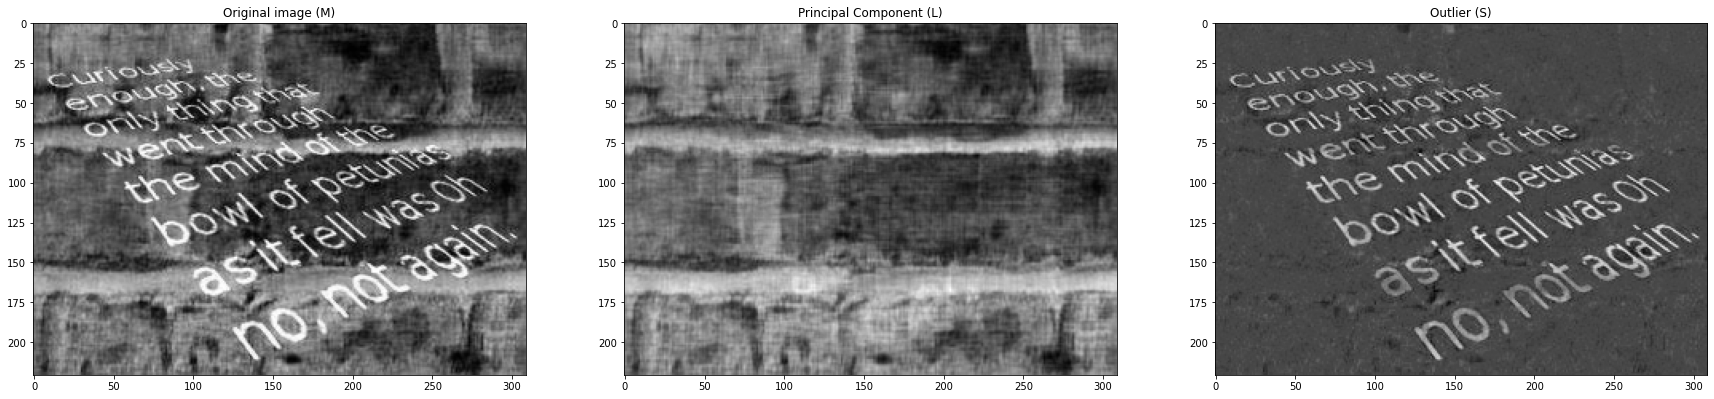

In [ ]:
image = Image.open("brick.png")
img = np.array(image) / 255.
principal, outlier = RPCA().fit(img)
RPCA.plot(img, principal, outlier)

## 4. Performance under different conditions [Q2]

### 4.1 Weight of L1 norm

In this section, we consider how sparse regularization affects the performance of RPCA. Specifically, we adjust the weight of L1 norm ```lamda``` to slightly lower and higher and discuss the results.

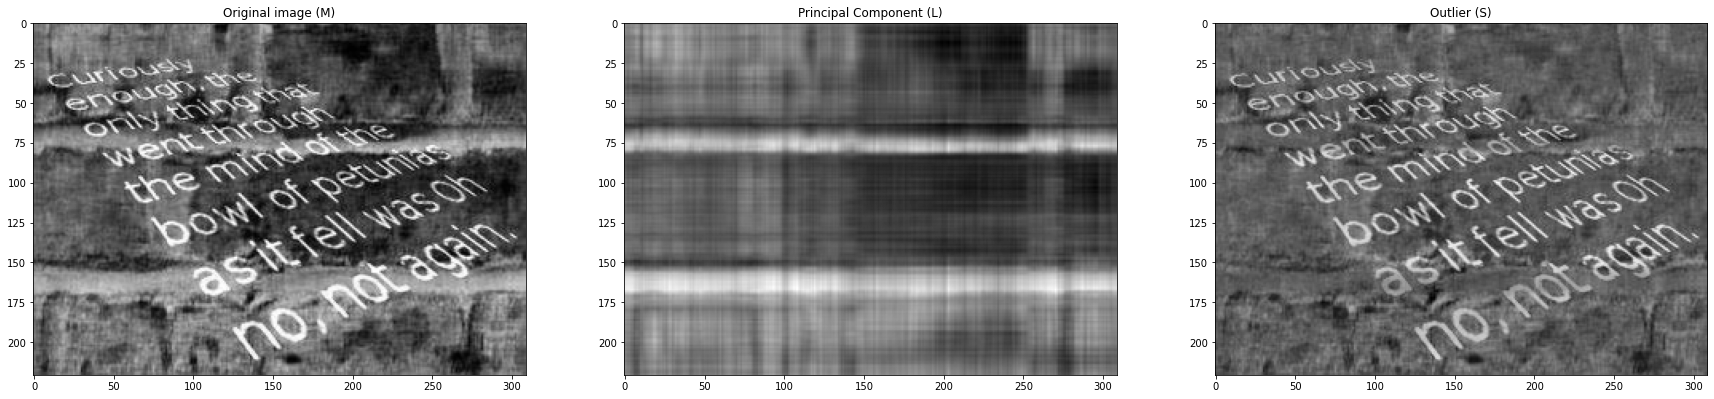

In [ ]:
"""
DEFAULT PARAMETER
RPCA: ld = 0.04, gamma = 1.0, iteration = 200
"""
#  lower sparse regularization
principal, outlier = RPCA(ld = 0.02).fit(img)
RPCA.plot(img, principal, outlier)

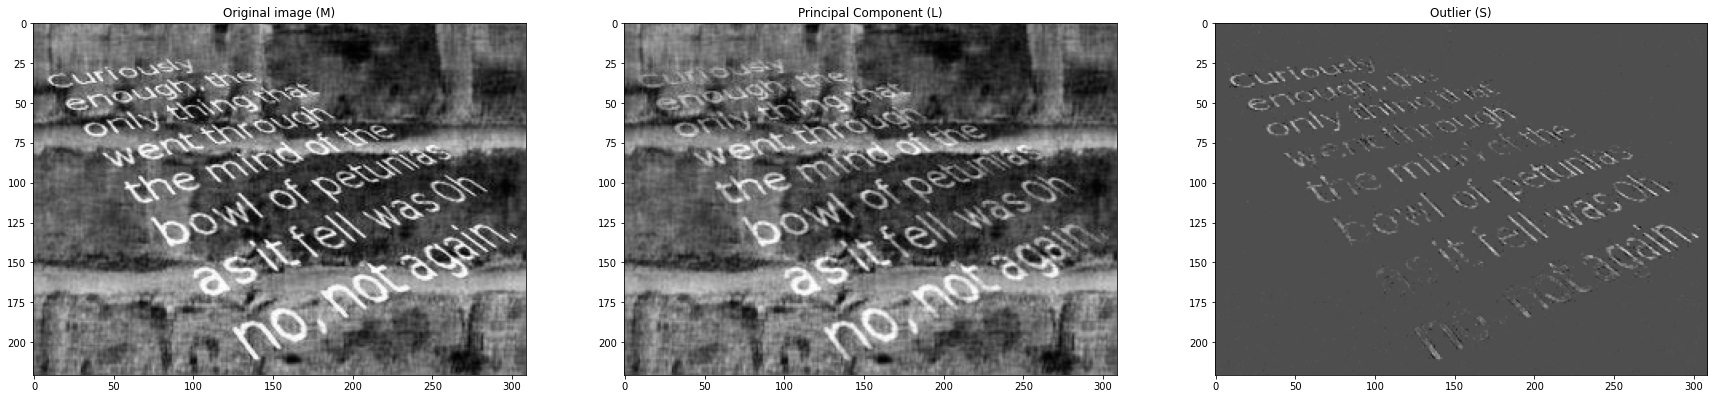

In [ ]:
# higher sparse regularization
principal, outlier = RPCA(ld = 0.1).fit(img)
RPCA.plot(img, principal, outlier)

From the results above, we can draw the following conclusions:
- With an exceedingly low sparse regularization, the outlier matrix $S$ naturally becomes less sparse. As a result, parts of the principal components (in this case, the brick wall) becomes more apparent.
- On the other hand, a high sparse regularization encorages the outlier matrix $S$ to be closer to a zero matrix. Consequently, some parts of the outliers (in this case, the passage) remains the principal component matrix $L$. Naturally, we can expect $S$ to becomes zero matrix when ```lamda``` approaches infinity.
- Hence, the regularization parameter must be carefully chosen to balance between these two extreme scenarios.

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=ceb3b963-7d26-4b9f-840e-3ecd7c45577b' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>